In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224,224)

In [3]:
dataset_url = 'http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz'
data_dir = keras.utils.get_file('groceries',origin=dataset_url ,cache_dir='.',untar=True)           #untar means unzip
data_dir

'./datasets/groceries'

In [4]:
data_dir = './datasets/images'

import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/images')

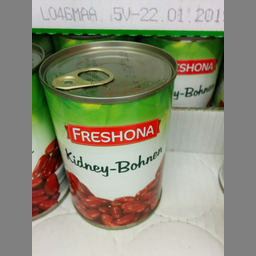

In [5]:
beans = list(data_dir.glob('BEANS/*.png'))[:5]
Image.open(beans[0])

In [6]:
len(list(data_dir.glob('*/*.png')))

4947

In [7]:
product_images_dict = {}
product_labels_dict = {}
label = 0
for folder in os.listdir(data_dir):
    product_images_dict[folder] = list(data_dir.glob(folder+'/*'))  
    product_labels_dict[folder] = label
    label+=1

In [8]:
product_images_dict['BEANS'][0]

PosixPath('datasets/images/BEANS/BEANS0000.png')

In [9]:
img = cv2.imread(str(product_images_dict['BEANS'][0]))
img.shape

(256, 256, 3)

In [10]:
cv2.resize(img,IMAGE_SHAPE).shape

(224, 224, 3)

In [11]:
X,y = [], []
for product_name, images in product_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,IMAGE_SHAPE)
        X.append(resized_img)
        y.append(product_labels_dict[product_name])

In [12]:
product_name = {}

for a,b in product_labels_dict.items():
  product_name[b]=a

In [16]:
X = np.array(X)
y = np.array(y)

In [17]:
from sklearn.model_selection import train_test_split as tts
X_train,X_test,y_train,y_test = tts(X,y,random_state=0)

In [18]:
X_train = X_train/255
X_test = X_test/255

In [19]:
#this gives the pretrained model except the last layer

feature_extractor_model_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model_url, input_shape = (224,224,3), trainable = False)

In [20]:
num_of_products = len(product_labels_dict)

model = tf.keras.Sequential([
      pretrained_model_without_top_layer,
      tf.keras.layers.Dense(num_of_products)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 25)                32025     
Total params: 2,290,009
Trainable params: 32,025
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

model.fit(X_train,y_train,epochs=25)

Epoch 1/25
116/116 [==============================] - 38s 45ms/step - loss: 2.2072 - acc: 0.3547
Epoch 2/25
116/116 [==============================] - 5s 41ms/step - loss: 1.2965 - acc: 0.6305
Epoch 3/25
116/116 [==============================] - 5s 41ms/step - loss: 0.9945 - acc: 0.7213
Epoch 4/25
116/116 [==============================] - 5s 41ms/step - loss: 0.8159 - acc: 0.7854
Epoch 5/25
116/116 [==============================] - 5s 40ms/step - loss: 0.6867 - acc: 0.8248
Epoch 6/25
116/116 [==============================] - 5s 41ms/step - loss: 0.5848 - acc: 0.8563
Epoch 7/25
116/116 [==============================] - 5s 41ms/step - loss: 0.5089 - acc: 0.8865
Epoch 8/25
116/116 [==============================] - 5s 41ms/step - loss: 0.4474 - acc: 0.9011
Epoch 9/25
116/116 [==============================] - 5s 40ms/step - loss: 0.3906 - acc: 0.9224
Epoch 10/25
116/116 [==============================] - 5s 40ms/step - loss: 0.3438 - acc: 0.9415
Epoch 11/25
116/116 [=================

In [22]:
model.evaluate(X_test,y_test)

39/39 [==============================] - 3s 50ms/step - loss: 0.9144 - acc: 0.7340


[0.914361298084259, 0.7340339422225952]

TOMATO_SAUCE
COFFEE


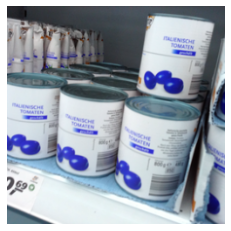

In [54]:
plt.axis('off')
i=146
plt.imshow(X_test[i])
print(product_name[y_test[i]])

predicted = model.predict(np.array([X_test[i]]))
predicted = np.argmax(predicted,axis=1)
print(product_name[predicted[0]])

JAM
JAM


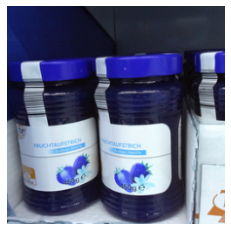

In [55]:
plt.axis('off')
i=149
plt.imshow(X_test[i])
print(product_name[y_test[i]])

predicted = model.predict(np.array([X_test[i]]))
predicted = np.argmax(predicted,axis=1)
print(product_name[predicted[0]])

CANDY
CANDY


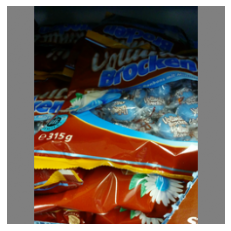

In [56]:
plt.axis('off')
i=197
plt.imshow(X_test[i])
print(product_name[y_test[i]])

predicted = model.predict(np.array([X_test[i]]))
predicted = np.argmax(predicted,axis=1)
print(product_name[predicted[0]])

In [51]:
model.save('final_model')